# LSTM Modelling 

In [2]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

## Data Refactor

In [3]:
dataset = pd.read_csv("../StationDateDatasets/datasetStationDate.csv").drop(columns=["Unnamed: 0"])

In [4]:
trips = pd.read_csv("../CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [5]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in dataset.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = np.delete(df, 2)

dataset = dataset.join(new_data)

In [6]:
dataset.to_csv("../StationDateDatasets/datasetStationDate.csv")

## Correlation Features

In [7]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = dataset[[col for col in dataset.columns if "Count" not in col]]
y = dataset['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 10436.527125289169),
 ('ATemp', 10280.850373783074),
 ('Year', 7092.1562101395475),
 ('Humidity', 4553.546738421971),
 ('Hour', 2521.675519475486),
 ('WeatherSituation', 1577.7531873242183),
 ('Day', 1020.0092383643951),
 ('StationEnd', 221.11531013433412),
 ('Windspeed', 189.9517425616836),
 ('Holiday', 56.248513129294146),
 ('Weekday', 47.644297362870226),
 ('WorkingDay', 39.98836012369895)]


## LSTM

In [23]:
epochs = 1
batch_size = 1
verbose = 2

MSE = [1.381881594657898, 1.3738893449306488, 1.6989500045776367, 1.6994145929813385, 1.698465597629547, 1.3719414472579956, 1.3812685370445252, 1.3771349608898162]

### Method 0
Input: c(t), StationEnd

Output: c(t+1)

In [9]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-06-30 17:40:52.905068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:40:52.905889: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-30 17:40:53.223798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gra

190755/190755 - 155s - loss: 1.5190 - accuracy: 0.3223 - 155s/epoch - 814us/step


2023-06-30 17:43:28.848887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 17:43:28.850223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 17:43:28.851247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190756/190756 - 155s - loss: 1.4301 - accuracy: 0.3453 - 155s/epoch - 815us/step
190756/190756 - 156s - loss: 1.4158 - accuracy: 0.3462 - 156s/epoch - 816us/step
190756/190756 - 155s - loss: 1.4164 - accuracy: 0.3426 - 155s/epoch - 811us/step
190756/190756 - 156s - loss: 1.4283 - accuracy: 0.3349 - 156s/epoch - 816us/step
190756/190756 - 155s - loss: 1.3836 - accuracy: 0.3480 - 155s/epoch - 812us/step
190756/190756 - 155s - loss: 1.3550 - accuracy: 0.3533 - 155s/epoch - 812us/step
190756/190756 - 155s - loss: 1.3495 - accuracy: 0.3547 - 155s/epoch - 813us/step
190756/190756 - 155s - loss: 1.3325 - accuracy: 0.3550 - 155s/epoch - 814us/step
190756/190756 - 156s - loss: 1.3668 - accuracy: 0.3463 - 156s/epoch - 817us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.8689717054367065 - Accuracy: 54.80750799179077%
-------------------------------------------

Text(0.5, 0, 'Methods')

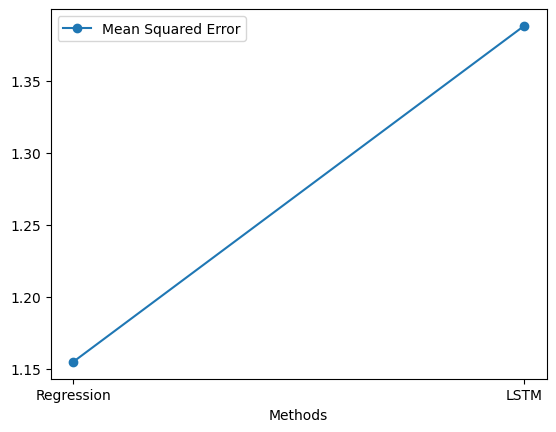

In [22]:
plt.plot(["Regression", "LSTM"], [1.1546453573093387, 1.3883113026618958], marker="o")
plt.legend(["Mean Squared Error"])
plt.xlabel("Methods")

### Method 1
Input: ..., Temp

Output: c(t+1)

In [11]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-06-30 18:06:51.645057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 18:06:51.646623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 18:06:51.647651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190755/190755 - 157s - loss: 1.5265 - accuracy: 0.3225 - 157s/epoch - 823us/step


2023-06-30 18:09:28.955149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 18:09:28.956261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 18:09:28.957152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190756/190756 - 156s - loss: 1.4291 - accuracy: 0.3452 - 156s/epoch - 816us/step
190756/190756 - 156s - loss: 1.4039 - accuracy: 0.3461 - 156s/epoch - 815us/step
190756/190756 - 156s - loss: 1.4032 - accuracy: 0.3426 - 156s/epoch - 815us/step
190756/190756 - 155s - loss: 1.4162 - accuracy: 0.3348 - 155s/epoch - 814us/step
190756/190756 - 156s - loss: 1.3679 - accuracy: 0.3476 - 156s/epoch - 815us/step
190756/190756 - 156s - loss: 1.3397 - accuracy: 0.3527 - 156s/epoch - 820us/step
190756/190756 - 155s - loss: 1.3344 - accuracy: 0.3539 - 155s/epoch - 815us/step
190756/190756 - 155s - loss: 1.3166 - accuracy: 0.3543 - 155s/epoch - 815us/step
190756/190756 - 156s - loss: 1.3547 - accuracy: 0.3456 - 156s/epoch - 820us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.906493067741394 - Accuracy: 54.80279326438904%
--------------------------------------------

### Method 2
Input: ..., Temp, ATemp

Output: c(t+1)

In [12]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-06-30 18:32:55.102495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 18:32:55.103657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 18:32:55.104522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190755/190755 - 158s - loss: 1.5211 - accuracy: 0.3216 - 158s/epoch - 827us/step


2023-06-30 18:35:33.033951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 18:35:33.035092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 18:35:33.035853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190756/190756 - 157s - loss: 1.4289 - accuracy: 0.3452 - 157s/epoch - 821us/step
190756/190756 - 156s - loss: 1.4001 - accuracy: 0.3462 - 156s/epoch - 819us/step
190756/190756 - 156s - loss: 1.3981 - accuracy: 0.3425 - 156s/epoch - 819us/step
190756/190756 - 157s - loss: 1.4089 - accuracy: 0.3345 - 157s/epoch - 821us/step
190756/190756 - 157s - loss: 1.3612 - accuracy: 0.3474 - 157s/epoch - 821us/step
190756/190756 - 156s - loss: 1.3352 - accuracy: 0.3529 - 156s/epoch - 819us/step
190756/190756 - 156s - loss: 1.3301 - accuracy: 0.3542 - 156s/epoch - 820us/step
190756/190756 - 156s - loss: 1.3151 - accuracy: 0.3547 - 156s/epoch - 820us/step
190756/190756 - 157s - loss: 1.3531 - accuracy: 0.3460 - 157s/epoch - 823us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.8698036074638367 - Accuracy: 54.78392243385315%
-------------------------------------------

### Method 3
Input: ..., Temp, ATemp, Year

Output: c(t+1)

In [13]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Year"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-06-30 18:59:06.611022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 18:59:06.612074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 18:59:06.612857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190755/190755 - 156s - loss: 1.7846 - accuracy: 0.3225 - 156s/epoch - 820us/step


2023-06-30 19:01:43.302331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 19:01:43.303359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 19:01:43.304016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190756/190756 - 156s - loss: 1.7200 - accuracy: 0.3453 - 156s/epoch - 816us/step
190756/190756 - 155s - loss: 1.7189 - accuracy: 0.3463 - 155s/epoch - 815us/step
190756/190756 - 155s - loss: 1.7300 - accuracy: 0.3428 - 155s/epoch - 813us/step
190756/190756 - 157s - loss: 1.7571 - accuracy: 0.3351 - 157s/epoch - 821us/step
190756/190756 - 155s - loss: 1.6880 - accuracy: 0.3481 - 155s/epoch - 813us/step
190756/190756 - 155s - loss: 1.6421 - accuracy: 0.3534 - 155s/epoch - 812us/step
190756/190756 - 155s - loss: 1.6419 - accuracy: 0.3548 - 155s/epoch - 813us/step
190756/190756 - 155s - loss: 1.6162 - accuracy: 0.3554 - 155s/epoch - 810us/step
190756/190756 - 155s - loss: 1.6919 - accuracy: 0.3468 - 155s/epoch - 814us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.930811882019043 - Accuracy: 54.80750799179077%
--------------------------------------------

### Method 4
Input: ..., Temp, ATemp, Year, Humidity

Output: c(t+1)

In [14]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Year", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-06-30 19:25:06.190697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 19:25:06.191756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 19:25:06.192544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190755/190755 - 156s - loss: 1.7864 - accuracy: 0.3224 - 156s/epoch - 815us/step


2023-06-30 19:27:41.960799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 19:27:41.961991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 19:27:41.962745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190756/190756 - 155s - loss: 1.7201 - accuracy: 0.3453 - 155s/epoch - 810us/step
190756/190756 - 155s - loss: 1.7189 - accuracy: 0.3463 - 155s/epoch - 812us/step
190756/190756 - 155s - loss: 1.7300 - accuracy: 0.3428 - 155s/epoch - 811us/step
190756/190756 - 154s - loss: 1.7571 - accuracy: 0.3351 - 154s/epoch - 809us/step
190756/190756 - 154s - loss: 1.6880 - accuracy: 0.3481 - 154s/epoch - 808us/step
190756/190756 - 154s - loss: 1.6421 - accuracy: 0.3534 - 154s/epoch - 809us/step
190756/190756 - 154s - loss: 1.6419 - accuracy: 0.3548 - 154s/epoch - 808us/step
190756/190756 - 154s - loss: 1.6162 - accuracy: 0.3554 - 154s/epoch - 810us/step
190756/190756 - 155s - loss: 1.6919 - accuracy: 0.3468 - 155s/epoch - 814us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9323486685752869 - Accuracy: 54.80750799179077%
-------------------------------------------

### Method 5
Input: ..., Temp, ATemp, Year, Humidity, WeatherSituation

Output: c(t+1)

In [15]:
dataset = pd.get_dummies(data=dataset, columns=["WeatherSituation"], dtype=int)

In [16]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Year", "Humidity", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-06-30 19:50:57.931132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 19:50:57.932526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 19:50:57.933295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190755/190755 - 157s - loss: 1.7918 - accuracy: 0.3214 - 157s/epoch - 821us/step


2023-06-30 19:53:34.800846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 19:53:34.801988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 19:53:34.802894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190756/190756 - 155s - loss: 1.7197 - accuracy: 0.3453 - 155s/epoch - 815us/step
190756/190756 - 155s - loss: 1.7185 - accuracy: 0.3463 - 155s/epoch - 815us/step
190756/190756 - 155s - loss: 1.7297 - accuracy: 0.3428 - 155s/epoch - 814us/step
190756/190756 - 155s - loss: 1.7568 - accuracy: 0.3351 - 155s/epoch - 813us/step
190756/190756 - 155s - loss: 1.6876 - accuracy: 0.3481 - 155s/epoch - 814us/step
190756/190756 - 156s - loss: 1.6417 - accuracy: 0.3534 - 156s/epoch - 816us/step
190756/190756 - 155s - loss: 1.6415 - accuracy: 0.3548 - 155s/epoch - 813us/step
190756/190756 - 155s - loss: 1.6159 - accuracy: 0.3554 - 155s/epoch - 814us/step
190756/190756 - 157s - loss: 1.6916 - accuracy: 0.3468 - 157s/epoch - 823us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9308792352676392 - Accuracy: 54.80750799179077%
-------------------------------------------

### Method 6
Input: ..., Temp, ATemp, Humidity, WeatherSituation

Output: c(t+1)

In [17]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-06-30 20:16:59.455131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 20:16:59.456140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 20:16:59.456925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190755/190755 - 156s - loss: 1.4874 - accuracy: 0.3221 - 156s/epoch - 820us/step


2023-06-30 20:19:36.136574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 20:19:36.137572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 20:19:36.138246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190756/190756 - 156s - loss: 1.3905 - accuracy: 0.3452 - 156s/epoch - 816us/step
190756/190756 - 155s - loss: 1.3781 - accuracy: 0.3462 - 155s/epoch - 814us/step
190756/190756 - 155s - loss: 1.3872 - accuracy: 0.3427 - 155s/epoch - 814us/step
190756/190756 - 156s - loss: 1.4026 - accuracy: 0.3350 - 156s/epoch - 817us/step
190756/190756 - 155s - loss: 1.3532 - accuracy: 0.3481 - 155s/epoch - 814us/step
190756/190756 - 155s - loss: 1.3264 - accuracy: 0.3534 - 155s/epoch - 814us/step
190756/190756 - 155s - loss: 1.3208 - accuracy: 0.3548 - 155s/epoch - 813us/step
190756/190756 - 156s - loss: 1.3066 - accuracy: 0.3554 - 156s/epoch - 819us/step
190756/190756 - 156s - loss: 1.3433 - accuracy: 0.3467 - 156s/epoch - 818us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.8399895429611206 - Accuracy: 54.80279326438904%
-------------------------------------------

### Method 7
Input: ..., Temp, ATemp, Humidity

Output: c(t+1)

In [18]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-06-30 20:43:01.255792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 20:43:01.257381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 20:43:01.258279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190755/190755 - 157s - loss: 1.5028 - accuracy: 0.3219 - 157s/epoch - 823us/step


2023-06-30 20:45:38.450483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 20:45:38.451553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 20:45:38.452352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190756/190756 - 156s - loss: 1.4017 - accuracy: 0.3451 - 156s/epoch - 820us/step
190756/190756 - 156s - loss: 1.3852 - accuracy: 0.3459 - 156s/epoch - 818us/step
190756/190756 - 155s - loss: 1.3937 - accuracy: 0.3423 - 155s/epoch - 814us/step
190756/190756 - 155s - loss: 1.4087 - accuracy: 0.3345 - 155s/epoch - 813us/step
190756/190756 - 155s - loss: 1.3625 - accuracy: 0.3476 - 155s/epoch - 813us/step
190756/190756 - 155s - loss: 1.3372 - accuracy: 0.3530 - 155s/epoch - 815us/step
190756/190756 - 156s - loss: 1.3326 - accuracy: 0.3545 - 156s/epoch - 820us/step
190756/190756 - 156s - loss: 1.3173 - accuracy: 0.3550 - 156s/epoch - 816us/step
190756/190756 - 156s - loss: 1.3545 - accuracy: 0.3464 - 156s/epoch - 818us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9161608219146729 - Accuracy: 54.80750799179077%
-------------------------------------------

### Method 8
Input: ..., Temp, ATemp, WeatherSituation

Output: c(t+1)

In [19]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=False)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

2023-06-30 21:09:05.063618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 21:09:05.064894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 21:09:05.065702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190755/190755 - 157s - loss: 1.5035 - accuracy: 0.3223 - 157s/epoch - 821us/step


2023-06-30 21:11:41.861498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 21:11:41.862814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 21:11:41.863666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190756/190756 - 156s - loss: 1.3999 - accuracy: 0.3452 - 156s/epoch - 816us/step
190756/190756 - 156s - loss: 1.3792 - accuracy: 0.3462 - 156s/epoch - 817us/step
190756/190756 - 156s - loss: 1.3864 - accuracy: 0.3427 - 156s/epoch - 816us/step
190756/190756 - 156s - loss: 1.4005 - accuracy: 0.3350 - 156s/epoch - 816us/step
190756/190756 - 156s - loss: 1.3553 - accuracy: 0.3481 - 156s/epoch - 816us/step
190756/190756 - 156s - loss: 1.3305 - accuracy: 0.3534 - 156s/epoch - 817us/step
190756/190756 - 157s - loss: 1.3249 - accuracy: 0.3548 - 157s/epoch - 821us/step
190756/190756 - 156s - loss: 1.3073 - accuracy: 0.3554 - 156s/epoch - 817us/step
190756/190756 - 159s - loss: 1.3427 - accuracy: 0.3468 - 159s/epoch - 834us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9033835530281067 - Accuracy: 54.80279326438904%
-------------------------------------------

## Graphs

Text(0.5, 0, 'Methods')

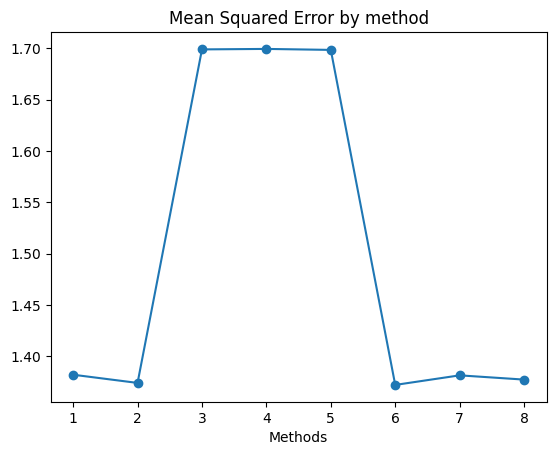

In [24]:
plt.plot(list(range(1,len(MSE)+1)), MSE, marker="o")
plt.title("Mean Squared Error by method")
plt.xlabel("Methods")

Text(0.5, 0, 'Methods')

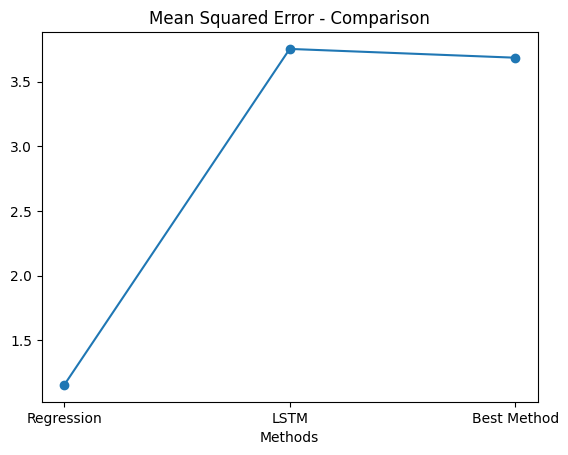

In [25]:
plt.plot(["Regression", "LSTM", "Best Method"], [1.1546453573093387, 3.7531802654266357, 3.6852662324905396], marker="o")
plt.title("Mean Squared Error - Comparison")
plt.xlabel("Methods")